* See detailed [code examples](https://github.com/ageron/handson-ml/blob/master/05_support_vector_machines.ipynb)
* [http://www.svms.org/](http://www.svms.org/)

## Linear SVM Classification
* Think of an SVM classifier as fitting the widest possible street between the classes, called *large margin classification*.
* SVMs are sensitive to the feature scales (pp. 146)
* *soft margin classification* finds a good balance between keeping the street as large as possible and limiting the *margin violations*

Minimize $$||\omega||^2+C\sum_{i=1}^m\xi$$ subject to: $$y_i(\omega\cdot x_i+b)\geq 1 - \xi_i, \quad \xi_i\geq0$$

<img src="images/05_soft_margin.PNG" alt="Soft margin" style="width: 300px;"/>

Let's first make some plotting functions.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    
    # Distance of the samples X to the separating hyperplane.
    y_decision = clf.decision_function(X).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

Now let's try SVM on the iris dataset.

In [2]:
import numpy as np
import os
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

svm_clf.predict([[5.5, 1.7]])

array([ 1.])

**SVC(kernel="linear", C=1)** is much slower than **LinearSVC**; **SGDClassifier(loss="hinge",alpha=1/(m*C))** does not converge as fast as **LinearSVC**, but can handle huge datasets that do not fit in memory, and online training.

## Nonlinear SVM Classification
Adding Polynomial Features for non-linearly separable data could be slow. Should use *kernel trick* instead.

In [3]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

### Polynomial Kernel

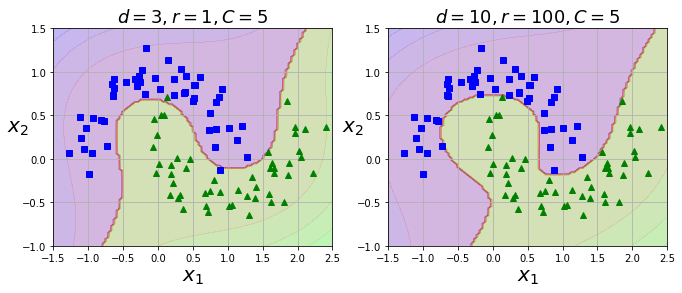

In [4]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)


plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

### Adding Similarity Features
The idea is to add features computed using a *similarity function* that measures how much each instance resembles a particular *landmark*.

$$\phi_\gamma(x,x)=\exp(-\gamma||x-l||^2)$$
This leads to the Gaussian RBF kernel.

One simple way to select the landmarks ($l$) is to create a landmark at the location of each and every instance in the dataset, downside being $m$ instances and $n$ features now becomes $m$ instances and $m$ features.

### Gaussian RBF Kernel

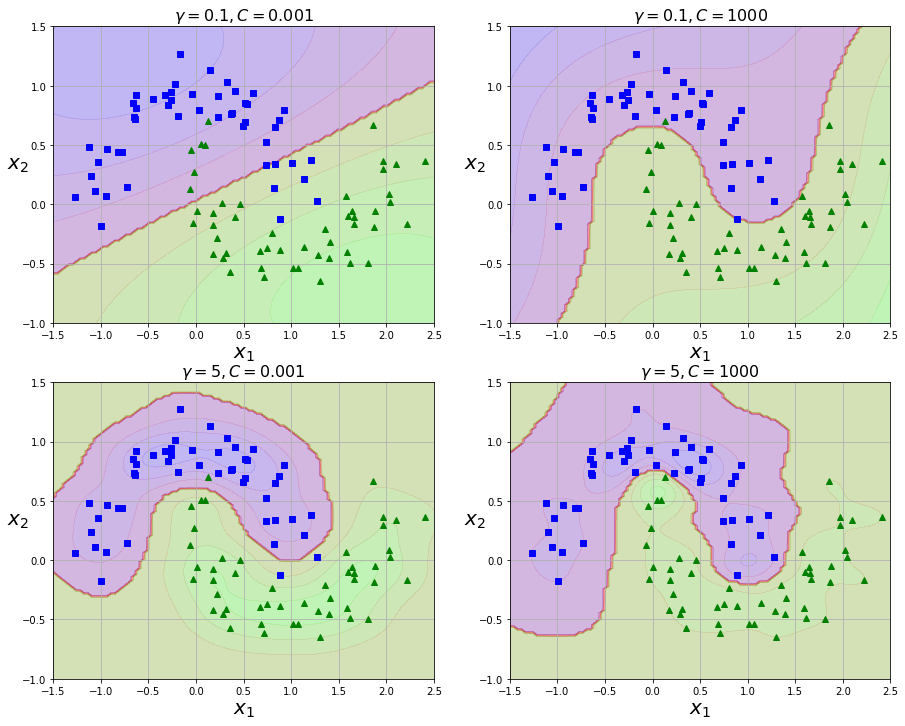

In [5]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(15, 12))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()

Increasing $\gamma$ makes the bell-shape curve narrower, and thus each instance's range of influence is smaller, and the decision boundary ends up being more irregular, wiggling around individual instances. So if the model is underfitting, increase $\gamma$; if overfitting, reduce $\gamma$.

Other kernels include *String kernels* for text document classification or DNA sequences.

**Choosing Kernels Rule-of-thumb:** linear kernel first (LinearSCV), then Gaussian RBF kernel, if having spare time and computing power, try a few others using cross-validation and grid search.

### Computational Complexity.
* LinearSVC is roughly $O(m\times n)$ but does not support kernel tricks
* SVC class supports kernel trick and is between $O(m^2\times n)$ and $O(m^3\times n)$. Notice that it scales well with the number of features.

## SVM Regression
* SVM regression tries to fit as many instances as possible on the street while limiting margin violations. The width of the street is controlled by a hyperparameter $\epsilon$
* A [SVR tutorial](http://www.svms.org/regression/SmSc98.pdf) by Smola and Scholkopf (1998).
* Hard margin SVM regression
<img src="images/05_hard_svr.PNG" alt="Hard Margin SVR" style="width: 300px;"/>
* Soft margin SVM regression
<img src="images/05_soft_svr1.PNG" alt="Soft Margin SVR" style="width: 300px;"/>
<img src="images/05_soft_svr2.PNG" alt="Soft Margin SVR" style="width: 180px;"/>
<img src="images/05_soft_svr3.PNG" alt="Soft Margin SVR" style="width: 350px;"/>
* Model is called $\epsilon-insensitive$, only points outside the street contribute to the cost insofar (i.e., $\xi_i$ and $ \xi_i^*$)
* Notice in the formulation above, the hyperparameter $C$ still controls the overall penalization level.


## Under the Hood

### Decision Function and Predictions
* Training a linear SVM classifier means findng the value $\omega$ and $b$ that make the margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).

### Training Objective
* Why are we minimizing $\omega$?

The slope of the decision function is equal to the norm of the weight vector ($||\omega||$). i.e., if we divide the slope by $2$, the points where the decision function is equal to $\pm 1$ are going to be twice as far away from the decision boundary, i.e., this will multiply the margin by $2$.So we minimize ($||\omega||$) to get a large margin. 

We need the decision function $\geq 1$ for all positive instances ($y^{(i)}=1$ or $t^{(i)}=1$) and $< -1$ for negative instances ($y^{(i)}=0$ or $t^{(i)}=-1$). Then, we have,

$$\underset{\omega, b}{\text{minimize}} \qquad \dfrac{1}{2}\omega^T\cdot\omega$$
$$\text{subject to }\qquad t^{(i)}(\omega^T\cdot \mathbf{x}^{(i)} +b)\geq1 \quad i=1,2,...,m$$


For soft margin linear SVM classifier:
$$\underset{\omega, b, \xi}{\text{minimize}} \qquad \dfrac{1}{2}\omega^T\cdot\omega + C\sum_{i=1}^{m}\xi^{(i)}$$
$$\text{subject to }\qquad t^{(i)}(\omega^T\cdot \mathbf{x}^{(i)} +b)\geq1-\xi^{(i)} \quad i=1,2,...,m$$

### The Dual Problem (Quadratic Programming)
$$\underset{\alpha}{\text{minimize}} \qquad \dfrac{1}{2}\sum_{i=1}^{m}\sum_{j=1}^{m}\alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}\mathbf{x}^{(i)}\mathbf{x}^{(j)}-\sum_{i=1}^{m}\alpha^{(i)}$$
$$\text{subject to }\qquad \alpha^{(i)} \geq 0 \quad i=1,2,...,m$$

### Kernelized SVM
* In Machine Learning, a *kernel* is a function capable of computing the dot product $\phi(\mathbf{a})^T\cdot\phi(\mathbf{b})$ based only on the original vectors $\mathbf{a}$ and $\mathbf{b}$, without having to compute or even knowing the transformation $\phi$
* Common kernels
    * Linear: $K(\mathbf{a},\mathbf{b})= \mathbf{a}^T\cdot\mathbf{b}$
    * Polynomial: $K(\mathbf{a},\mathbf{b})= (\gamma \mathbf{a}^T \cdot \mathbf{b}+r)^d$
    * Gaussian RBF: $K(\mathbf{a},\mathbf{b})= \exp(\gamma||\mathbf{a}-\mathbf{b}||^2)$
    * Sigmoid: $K(\mathbf{a},\mathbf{b})=\tanh(\gamma \mathbf{a}^T \cdot \mathbf{b}+r)$
    
**Mercer's Theorem**: If *Mercer's* conditions ($K$ must be continuous, symmetric in arguments), then $\exists \phi$ that maps $\mathbf{a}$ and $\mathbf{b}$ into another space such that $K(\mathbf{a},\mathbf{b})=\phi(\mathbf{a})^T\cdot\phi(\mathbf{b})$. So we can use $K$ as we know $\phi$ exists, even if we don't know what $\phi$ is.

In case of Gaussian RBF kernel, $\phi$ actually maps the instance to an infinite-dimensional space.

With the help of the *kernel trick*, we can actually make predictions without calculating $\hat{\mathbf{\omega}}$, instead we have $h_{\hat{\omega},\hat{b}}(\phi(\mathbf{x}^{(n)}))=\underset{\hat{\alpha}^{(i)}>0}{\sum_{i=1}^{m}} \hat{\alpha}^{(i)}t^{(i)}K(\mathbf{x}^{(i)},\mathbf{x}^{(n)})+\hat{b}$. Where $\hat{b}$ can be calculated using kernel trick similarly.

* Check is [知乎 Notes](https://zhuanlan.zhihu.com/p/29226227) on Kenel SVM, it's based on Prof. 林田轩's ML class, and uses a slightly different notation.

### Online SVMs
* Hinge Loss $max(0, 1-t)$
* Oneline Linear SVM classifier cost function $$J(\mathbf{\omega}, b)=\dfrac{1}{2}\mathbf{\omega}^T\cdot\mathbf{\omega}+C\sum_{i=1}^{m}max(0,1-t^{(i)}(\mathbf{\omega}^T\cdot\mathbf{x}^{(i)}+b))$$
* Online kernelized SVMs requires fancier algorithms implemented in Matlab and C++. For large-scale nonlinear problems, neural networks are recommended.